In [82]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import seaborn as sns
import torch

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
import itertools
palette = itertools.cycle(sns.color_palette())

from func import get_data

# fix random generator seed (for reproducibility of results)
#np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

# Read the CSV file into a pandas DataFrame and display the first few rows
X_train,y_train,X_test,y_test,age,sfd = get_data(True,True)


print("Training Dataset size:", len(X_train))
print("Test Dataset size:", len(X_test))

print('Training data shape: ',X_train.shape)
print('Test data shape: ',X_test.shape)

ind_train = age[0].astype("int")
ind_test = age[1].astype("int")



#________________________________________________

Training Dataset size: 1025
Test Dataset size: 303
Training data shape:  (1025, 30)
Test data shape:  (303, 30)


In [229]:
def hierarchical_model(X, ind, n_cat, n_ind, obs=None):
    n_obs, n_features = X.shape

    beta = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1], n_cat), 1).to_event())    
    mu = pyro.sample("alpha_mu", dist.Normal(0., 10.).expand([n_cat]).to_event())
    sigma = pyro.sample("alpha_sigma", dist.HalfCauchy(10.).expand([n_cat]).to_event())
    
    # i individuals
    with pyro.plate("alpha_plate", n_ind):
        alpha = pyro.sample("alpha", dist.Normal(mu, sigma).to_event())    
        #print("aplha shape: ", alpha.shape)
        
    # Priors
    # n features
    with pyro.plate("beta_plate", n_obs):
        #print("alpha ind shape: ", alpha[ind].shape)
        #print("beta ind ", beta.shape)
        #print("shape: ", X.matmul(beta).shape)
        val = alpha[ind] + X.matmul(beta)
        pyro.sample("obs", dist.Categorical(logits=val), obs=obs)

def hierarchical_model_correct(X, ind, n_cat, n_ind, hyp_param, obs=None):
    n_obs, n_features = X.shape
    
    # Hyperpriors for the hierarchical intercept alpha
    mu = pyro.sample("alpha_mu", dist.Normal(0., hyp_param[2]).expand([n_cat]).to_event(1))
    sigma = pyro.sample("alpha_sigma", dist.HalfCauchy(hyp_param[3]).expand([n_cat]).to_event(1))
    
    # Hierarchical prior for individual-specific alpha and beta
    with pyro.plate("individuals", n_ind):
        alpha = pyro.sample("alpha", dist.Normal(mu, sigma).to_event(1))  # Shape: [n_ind, n_cat]
        beta = pyro.sample("beta", dist.Normal(torch.zeros(n_features, n_cat), 1).to_event(2))  # Shape: [n_ind, n_features, n_cat]

    # Observation model
    with pyro.plate("data", n_obs):
        # Use the individual-specific alpha and beta values
        alpha_obs = alpha[ind]
        beta_obs = beta[ind]
        val = alpha_obs + torch.einsum('ij,ijk->ik', X, beta_obs)
        
        pyro.sample("obs", dist.Categorical(logits=val), obs=obs)

def hierarchical_model_ARD(X, ind, n_cat, n_ind, hyp_param, obs=None):
    n_obs, n_features = X.shape
    
    # Hyperprior for the variance of beta
    a = pyro.sample("a", dist.Gamma(hyp_param[0]*torch.ones(n_features, 1), hyp_param[1]*torch.ones(n_features, 1)).to_event())
    
    # Hyperpriors for the hierarchical intercept alpha
    mu = pyro.sample("alpha_mu", dist.Normal(0., hyp_param[2]).expand([n_cat]).to_event(1))
    sigma = pyro.sample("alpha_sigma", dist.HalfCauchy(hyp_param[3]).expand([n_cat]).to_event(1))
    
    # Hierarchical prior for individual-specific alpha and beta
    with pyro.plate("individuals", n_ind):
        alpha = pyro.sample("alpha", dist.Normal(mu, sigma).to_event(1))  # Shape: [n_ind, n_cat]
        beta = pyro.sample("beta", dist.Normal(torch.zeros(n_features, n_cat), a).to_event(2))  # Shape: [n_ind, n_features, n_cat]

    # Observation model
    with pyro.plate("data", n_obs):
        # Use the individual-specific alpha and beta values
        alpha_obs = alpha[ind]
        beta_obs = beta[ind]
        val = alpha_obs + torch.einsum('ij,ijk->ik', X, beta_obs)
        
        pyro.sample("obs", dist.Categorical(logits=val), obs=obs)


In [235]:
# Prepare data for Pyro model
n_cat = int(y_train.max())
#print('n_cat', n_cat)
n_ind = ind_train.max()
#print('n_ind', n_ind)
X_train_tensor = torch.tensor(X_train.astype('float')).float()
y_train_tensor = torch.tensor(y_train).float()
#print(y_train_tensor)
ind_train = torch.tensor(ind_train) # these are indices, therefore they need to be (long) integers

model = hierarchical_model_correct

# Define guide function
guide = AutoDiagonalNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 500

hyp_param = [1,1,1,1]

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# List to store ELBO values
elbo_values = []

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_tensor, ind_train, n_cat+1, n_ind+1, hyp_param, y_train_tensor)
    elbo_values.append(elbo)  # Store ELBO value
    if step % 5000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))
        #print('')


/var/folders/rl/2d6x2yy927z8k4n7s2v1ng3m0000gn/T/ipykernel_9791/4147915518.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ind_train = torch.tensor(ind_train) # these are indices, therefore they need to be (long) integers


[0] ELBO: 1365.7


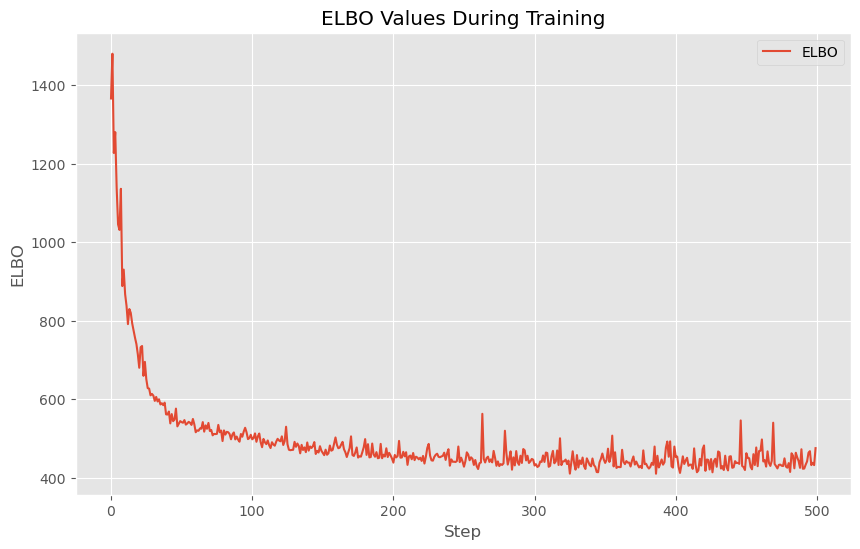

In [236]:
# Plot ELBO values
plt.figure(figsize=(10, 6))
plt.plot(elbo_values, label='ELBO')
plt.xlabel('Step')
plt.ylabel('ELBO')
plt.title('ELBO Values During Training')
plt.legend()
plt.show()

In [237]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("beta", "alpha", "alpha_mu", "alpha_sigma"))
samples = predictive(X_train_tensor, ind_train, n_cat+1, n_ind+1, hyp_param, y_train_tensor)

beta_samples = samples["beta"].detach().numpy()
alpha_samples = samples["alpha"].detach().numpy()
alpha_mu_samples = samples["alpha_mu"].detach().numpy()
alpha_sigma_samples = samples["alpha_sigma"].detach().numpy()



In [238]:
# Compute the expected values of the parameters
alpha_hat = alpha_samples.mean(axis=0)  # Shape: [n_ind, n_cat]
beta_hat = beta_samples.mean(axis=0)  # Shape: [n_features, n_cat]

n,p = X_test.shape

y_hat = np.zeros((n,2))
for i in range(n):
    if ind_test[i] == 0:
        y_hat[i,:] = alpha_hat[0,:] + np.dot(X_test[i,:], beta_hat[0,:,:])
    else:
        y_hat[i,:] = alpha_hat[1,:] + np.dot(X_test[i,:], beta_hat[1,:,:])

y_hat = np.argmax(y_hat, axis=1)
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))



Accuracy: 0.8712871287128713


In [67]:
#a_samples = samples["a"].detach().numpy()
beta_samples = samples["beta"].detach().numpy()
alpha_samples = samples["alpha"].detach().numpy()
alpha_mu_samples = samples["alpha_mu"].detach().numpy()
alpha_sigma_samples = samples["alpha_sigma"].detach().numpy()

In [68]:
print(beta_samples.shape)

(4000, 1, 30, 2)


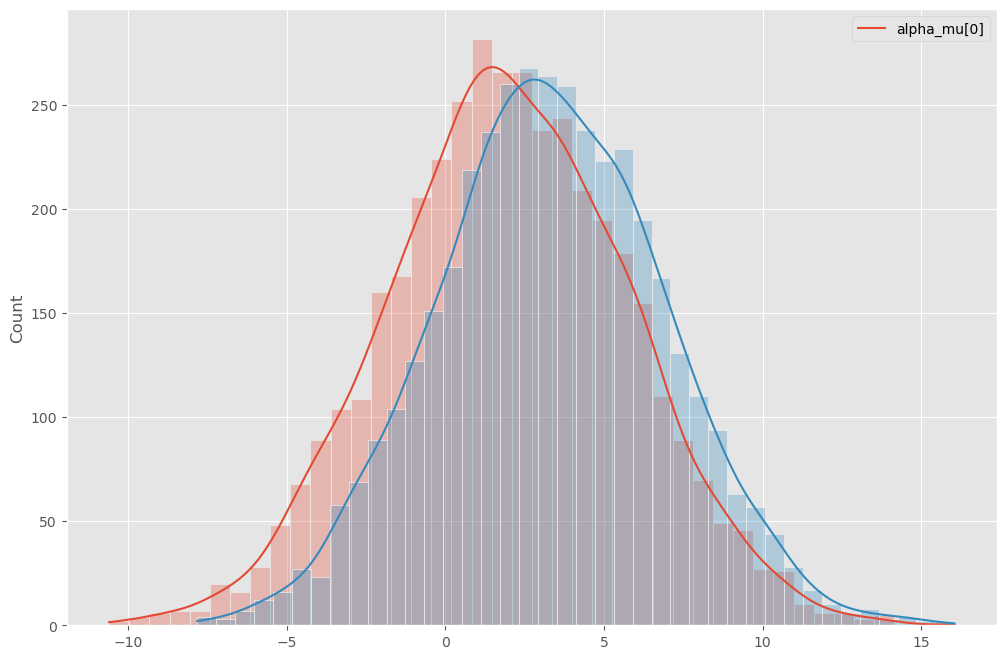

In [9]:
for c in range(n_cat+1):
    sns.histplot(alpha_mu_samples[:,0,c], kde=True, alpha=0.3)
plt.legend(["alpha_mu[%d]" % c for c in range(n_cat)])
plt.show()

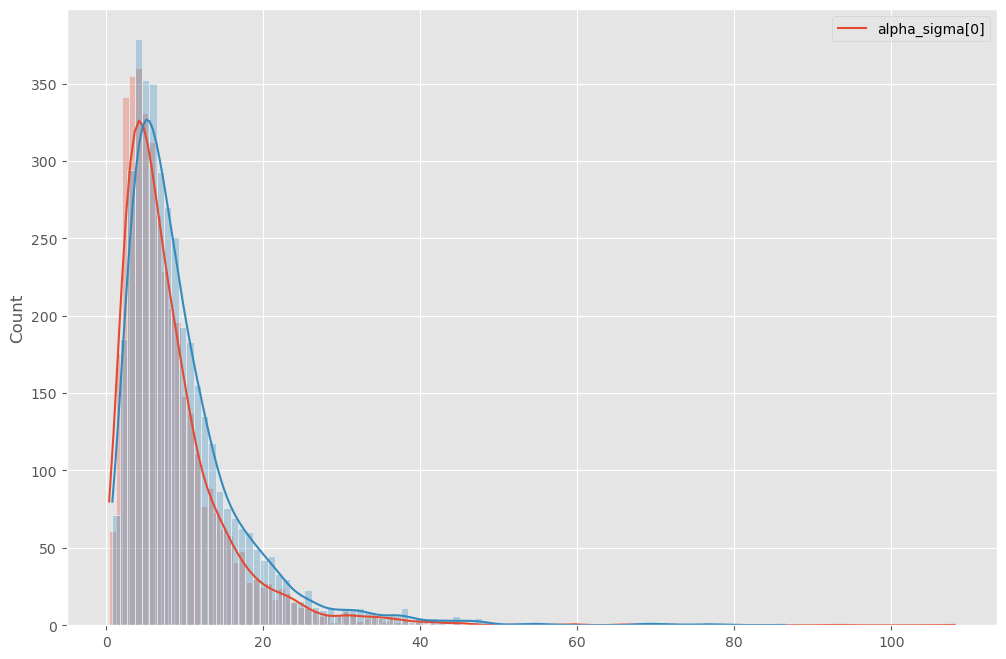

In [10]:
for c in range(n_cat+1):
    sns.histplot(alpha_sigma_samples[:,0,c], kde=True, alpha=0.3)
plt.legend(["alpha_sigma[%d]" % c for c in range(n_cat)])
plt.show()

In [11]:
# extract expected values of the parameters
alpha_hat = alpha_samples.mean(axis=0)
beta_hat = beta_samples.squeeze().mean(axis=0)

print(beta_hat[5:7,0])
print(beta_hat[5:7,1])

[-0.057882    0.81732213]
[ 0.03072938 -0.8117543 ]


In [12]:
# make predictions for test set
y_hat = alpha_hat[ind_test-1,:] + np.dot(X_test, beta_hat)
y_hat = np.argmax(y_hat, axis=1) + 1
print("predictions:", y_hat-1)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat-1 == y_test) / len(y_test))

predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1
 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0
 1 0 0 1 0 0 1]
true values: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0